In [3]:
import sys
sys.path.append("../")

import torch
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch_geometric.utils import to_dense_adj

from models.LASE_unshared_normalized import LASE
from models.SVD_truncate import embed_scipy, align_Xs

# Load the config file
with open('../data/data_config.json', 'r') as file:
    config = json.load(file)

# SBM-3

In [8]:
torch.manual_seed(42)


gd_steps = 5
device = 'cpu'

dataset = 'sbm3_unbalanced_positive_subgraphs'

d = config[dataset]['d']
p = config[dataset]['p']
n = np.array(config[dataset]['n'])
num_nodes = np.sum(n)

lase = LASE(d, d, gd_steps)
lase.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_FULL.pt'))
lase.to(device)
lase.eval()


ORIGINAL_GRAPH = '../data/sbm3_unbalanced_positive_subgraphs_original_graph.pkl'
with open(ORIGINAL_GRAPH, 'rb') as f:
    data= pickle.load(f)


num_nodes = data.num_nodes
edge_index = data.edge_index
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
x = torch.rand((num_nodes, d)).to(device)

x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss)
x_lase = x_lase.to('cpu')

x_svd = embed_scipy(edge_index,d)
loss = np.linalg.norm((x_svd@x_svd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss)

x_lase_p = align_Xs(x_lase,x_svd)

Loss LASE shared weights (5 layers):  tensor(4295.8354)
Loss RDPG SVD Truncate:  4497.657


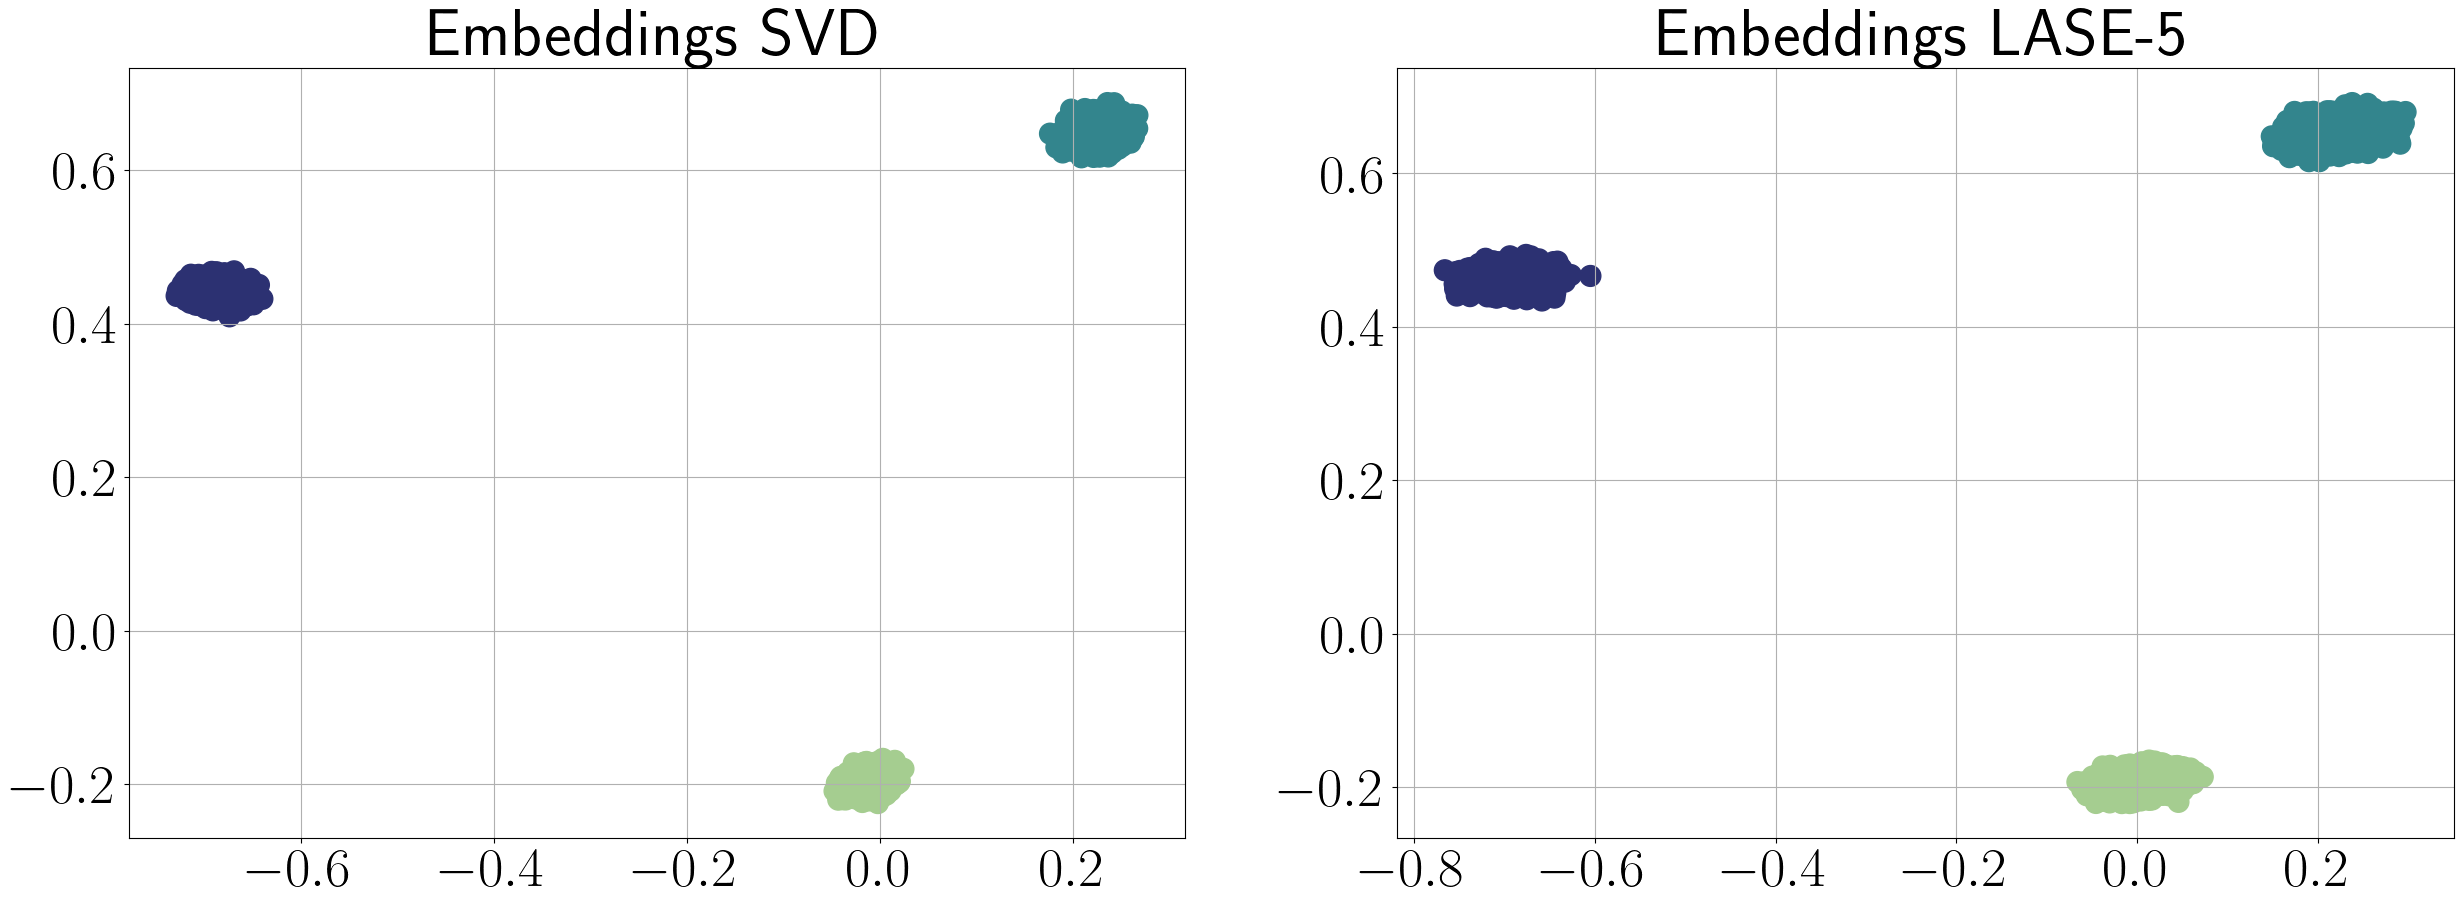

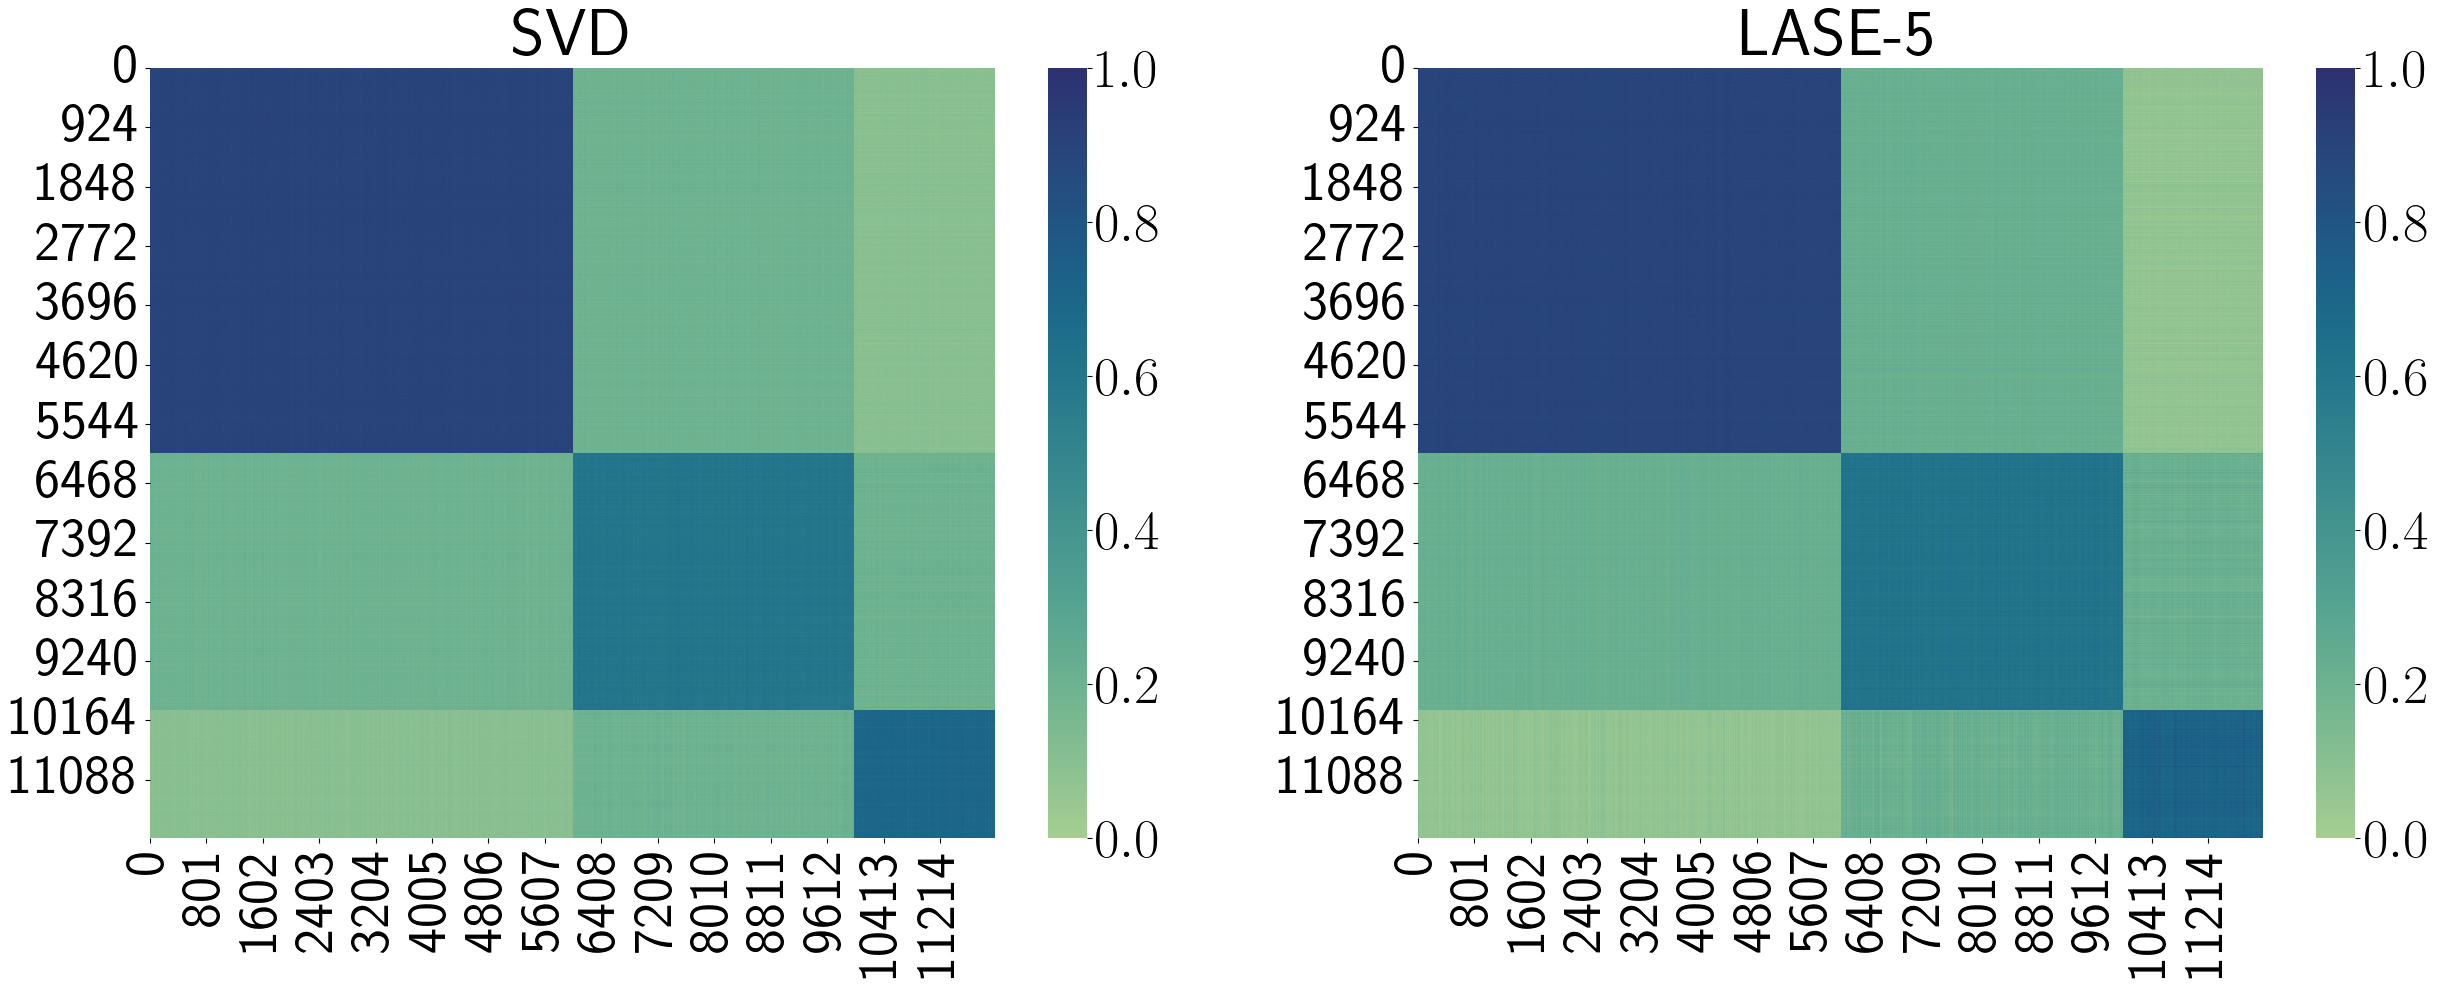

In [9]:
colors = np.concatenate((np.ones(n[0]),np.ones(n[1])*2,np.ones(n[2])*3))

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 40
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = False

plt.rcParams['axes.grid'] = True
fig, axes = plt.subplots(1, 2, figsize =(30,10))
axes[0].set_title('Embeddings SVD')
axes[0].scatter(x_svd[:,0],x_svd[:,1], c=colors, cmap="crest")
axes[1].set_title(f'Embeddings LASE-{gd_steps}')
axes[1].scatter(x_lase_p[:,0],x_lase_p[:,1], c=colors, cmap="crest")
plt.show()

plt.rcParams['axes.grid'] = False
fig, axes = plt.subplots(1, 2, figsize =(30,10))
axes[0].set_title('SVD')
sns.heatmap(x_svd@x_svd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
axes[1].set_title(f'LASE-{gd_steps}')
sns.heatmap(x_lase@x_lase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
plt.show()